# **Gaussian vs. Gaussian Mixture Models for MNIST Classification**

This notebook compares the performance of a **Single Gaussian Model (SGM)** against a **Gaussian Mixture Model (GMM)** for classifying the **MNIST handwritten digits dataset**.  
The goal is to analyze how each probabilistic model represents digit distributions and how effectively they can classify unseen samples.

---

## **1. Setup: Importing Libraries and Loading Data**

In this section, we:
- Import the required **Python libraries**.
- Load the **MNIST dataset** (containing 60,000 training and 10,000 testing images of handwritten digits 0–9).
- **Normalize** the pixel values to the range [0, 1].
- Apply **Principal Component Analysis (PCA)** to reduce dimensionality and retain the most informative features.

---

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from scipy.stats import multivariate_normal as mvn
from sklearn.decomposition import PCA
from scipy.special import logsumexp
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28*28).astype(np.float64) / 255.0
X_test = X_test.reshape(-1, 28*28).astype(np.float64) / 255.0

pca = PCA(n_components=60)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("MNIST dataset loaded successfully.")
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

print("Shape after PCA:", X_train_pca.shape)


2025-11-02 22:47:37.699564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762123658.007913      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762123658.091532      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST dataset loaded successfully.
Training shape: (60000, 784)
Testing shape: (10000, 784)
Shape after PCA: (60000, 60)


## **2. Model 1: Single Gaussian Model**
In this section, we implement a classifier where each class (digit) is modeled by a single multivariate Gaussian distribution.

### 2.1. Training the Gaussian Model
The `TrainGaussianModel` function calculates the mean and covariance for each class from the training data. *italicized text*

In [2]:
def TrainGaussianModel(X_train, y_train):
  class_labels = np.unique(y_train)
  columns_num = X_train.shape[1]
  means = []
  covs = []
  for c in class_labels:
    class_data = X_train[y_train == c]
    means.append(class_data.mean(axis=0))
    reg = np.eye(columns_num) * 1e-3
    covs.append(np.cov(class_data.T) + reg)
  return class_labels, means, covs


### 2.2. Testing the Gaussian Model
The `TestGaussianModel` function predicts the class for each test sample by finding which class's Gaussian distribution has the maximum likelihood.

In [3]:
def TestGaussianModel(X_test, class_labels, means, covs):
  TestImageNum = X_test.shape[0]
  nc = len(class_labels)
  log_likelihoods = np.zeros((TestImageNum, nc))
  for i in range(nc):
    log_likelihoods[:, i] = mvn.logpdf(X_test, mean=means[i], cov=covs[i])
  indices = np.argmax(log_likelihoods, axis=1)
  y_pred = np.array([class_labels[i] for i in indices])
  return y_pred, log_likelihoods

### 2.3. Running the Model and Comparing Predictions

Here, we execute the training and testing functions defined above. We then print the array of predicted values and the array of actual test values to visually inspect the model's performance on a sample of the data.

In [4]:
class_labels, means, covs = TrainGaussianModel(X_train_pca, y_train)
y_pred_gaussian, log_likelihoods_gaussian = TestGaussianModel(X_test_pca, class_labels, means, covs)

In [5]:

print(f"Predicted Values (first 50): {y_pred_gaussian[:50]}")
print("-----------------------------------------------------------------------")
print(f"Actual Values    (first 50): {y_test[:50]}")


Predicted Values (first 50): [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4]
-----------------------------------------------------------------------
Actual Values    (first 50): [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4]


**Output Analysis:**
As seen in the output, the Gaussian model correctly predicts a vast majority of the digits, providing a good initial indication of its effectiveness. The next step is to quantify this performance using an accuracy metric.

##  **3. Model 2: Gaussian Mixture Model (GMM)**


In this section, we enhance the classification approach by representing each class (digit) as a **mixture of multiple Gaussian components** instead of a single Gaussian distribution.  
This allows the model to capture **complex, multimodal distributions** within each digit class.

---

### 3.1. Training the Gaussian Mixture Model

The **`TrainGMM_core`** function implements the **Expectation-Maximization (EM)** algorithm to estimate the parameters of a Gaussian Mixture Model:
- **Initialization:** Randomly selects initial means and sets equal weights and identity covariances.
- **E-step:** Computes the responsibility of each component for every sample.
- **M-step:** Updates the component weights, means, and covariances based on these responsibilities.
- **Convergence:** Stops when the change in log-likelihood is below the tolerance threshold.

In [6]:
def TrainGMM_core(X, n_components=4, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape

    rng = np.random.default_rng(seed=42)
    random_indices = rng.choice(n_samples, n_components, replace=False)
    means = X[random_indices]

    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    weights = np.ones(n_components) / n_components

    prev_log_likelihood = -np.inf

    for i in range(max_iter):
        log_likelihoods = np.zeros((n_samples, n_components))
        for k in range(n_components):
            log_pdf = mvn.logpdf(X, mean=means[k], cov=covariances[k], allow_singular=True)
            log_likelihoods[:, k] = np.log(weights[k]) + log_pdf

        log_total_likelihood = logsumexp(log_likelihoods, axis=1, keepdims=True)

        log_responsibilities = log_likelihoods - log_total_likelihood
        responsibilities = np.exp(log_responsibilities)

        # Max Step
        Nk = np.sum(responsibilities, axis=0) + 1e-10
        weights = Nk / n_samples
        means = (responsibilities.T @ X) / Nk[:, np.newaxis]

        for k in range(n_components):
            diff = X - means[k]
            cov_k = (responsibilities[:, k, np.newaxis] * diff).T @ diff / Nk[k]
            covariances[k] = cov_k + 1e-6 * np.eye(n_features)

        new_log_likelihood = np.sum(np.log(log_total_likelihood))
        if abs(new_log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = new_log_likelihood

    return weights, means, covariances

In [7]:
def TrainGMM(X_train, y_train, n_components=2):
    class_labels = np.unique(y_train)
    gmm_params = {}
    for c in class_labels:
        class_data = X_train[y_train == c]
        weights, means, covariances = TrainGMM_core(class_data, n_components=n_components)
        gmm_params[c] = {'weights': weights, 'means': means, 'covs': covariances}

    return gmm_params

### 3.2. Testing the Gaussian Mixture Model

After training the GMM for each digit class, we evaluate its performance on the test data.  
This step computes how well each sample fits into each class’s learned distribution and assigns the most probable label.



In [8]:
def TestGMM_core(X_test, weights, means, covariances):
    n_components = len(weights)
    likelihoods = np.zeros((X_test.shape[0], n_components))

    for k in range(n_components):
        n_features = means[k].shape[0]
        cov_k = covariances[k] + 1e-6 * np.eye(n_features)
        likelihoods[:, k] = weights[k] * mvn.pdf(X_test, mean=means[k], cov=cov_k)

    log_likelihood = np.log(np.sum(likelihoods, axis=1))
    return log_likelihood

In [9]:
def TestGMM(X_test, gmm_params):
    class_labels = sorted(gmm_params.keys())
    log_likelihoods = np.zeros((X_test.shape[0], len(class_labels)))

    for i, c in enumerate(class_labels):
        params = gmm_params[c]
        log_likelihoods[:, i] = TestGMM_core(X_test, params['weights'], params['means'], params['covs'])

    indices = np.argmax(log_likelihoods, axis=1)
    y_pred = np.array([class_labels[i] for i in indices])

    return y_pred, log_likelihoods

### 3.3. Running the Model and Comparing Predictions

Here, we execute the training and testing functions defined above. We then print the array of predicted values and the array of actual test values to visually inspect the model's performance on a sample of the data.

In [10]:
gmm_params = TrainGMM(X_train_pca, y_train)
y_pred_gmm, log_likelihoods_gmm = TestGMM(X_test_pca, gmm_params)

/tmp/ipykernel_13/3174770336.py:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(np.sum(likelihoods, axis=1))


In [11]:
print(f"Predicted Values (first 50): {y_pred_gmm[:50]}")
print("-----------------------------------------------------------------------")
print(f"Actual Values    (first 50): {y_test[:50]}")


Predicted Values (first 50): [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4]
-----------------------------------------------------------------------
Actual Values    (first 50): [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4]


**Output Analysis:**  
As observed in the output, the **Gaussian Mixture Model (GMM)** successfully classifies the majority of digits with high accuracy.  
Its mixture-based structure enables it to **capture complex and overlapping data distributions**


## **4. Calculating Empirical Accuracy**

To **quantify the overall performance** of each model, we define a function called **`calculate_accuracy`**.  
This function measures how often the model's predictions match the true labels by calculating the **ratio of correct predictions** to the **total number of samples**.

A higher accuracy value indicates a more reliable and effective classification model.

---

In [12]:
def calculate_accuracy(y_true, y_pred):
    correct_count = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct_count += 1
    accuracy = correct_count / len(y_true)
    return accuracy

In [13]:
gaussian_accuracy = calculate_accuracy(y_test,y_pred_gaussian)
print(f"The Emperical Accuracy for Gaussian Model is: {gaussian_accuracy}")
gmm_accuracy = calculate_accuracy(y_test,y_pred_gmm)
print(f"The Emperical Accuracy for Gaussian Mixture Model is: {gmm_accuracy}")


The Emperical Accuracy for Gaussian Model is: 0.9616
The Emperical Accuracy for Gaussian Mixture Model is: 0.9638


**Result:**  
The **Single Gaussian Model (SGM)** achieves an impressive empirical accuracy of **96.16%**, while the **Gaussian Mixture Model (GMM)** attains a slightly higher accuracy of **96.41%**.  

This indicates that both models are **highly effective** for this classification task, with the GMM showing a **marginal yet consistent improvement** in overall performance.

---

### **5. Plotting Empirical ROC Curves**

To **evaluate the classification performance** of both models on a per-class basis, we plot the **Receiver Operating Characteristic (ROC)** curves for each of the 10 digits (**0–9**).

Each ROC curve visualizes the trade-off between the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)** at various threshold values.  
A curve closer to the **top-left corner** represents **better classification performance**.

---

In [14]:
def calculate_roc_points(y_true_binary, scores):
  N1 = np.sum(y_true_binary)
  N0 = len(y_true_binary) - N1
  thresholds = np.unique(scores)
  thresholds = np.sort(thresholds)[::-1]
  tpr_list = []
  fpr_list = []
  for th in thresholds:
    preds = (scores >= th).astype(int)
    tp = np.sum((preds == 1) & (y_true_binary == 1))
    fp = np.sum((preds == 1) & (y_true_binary == 0))
    tpr = tp / (N1)
    fpr = fp / (N0)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
  return fpr_list, tpr_list

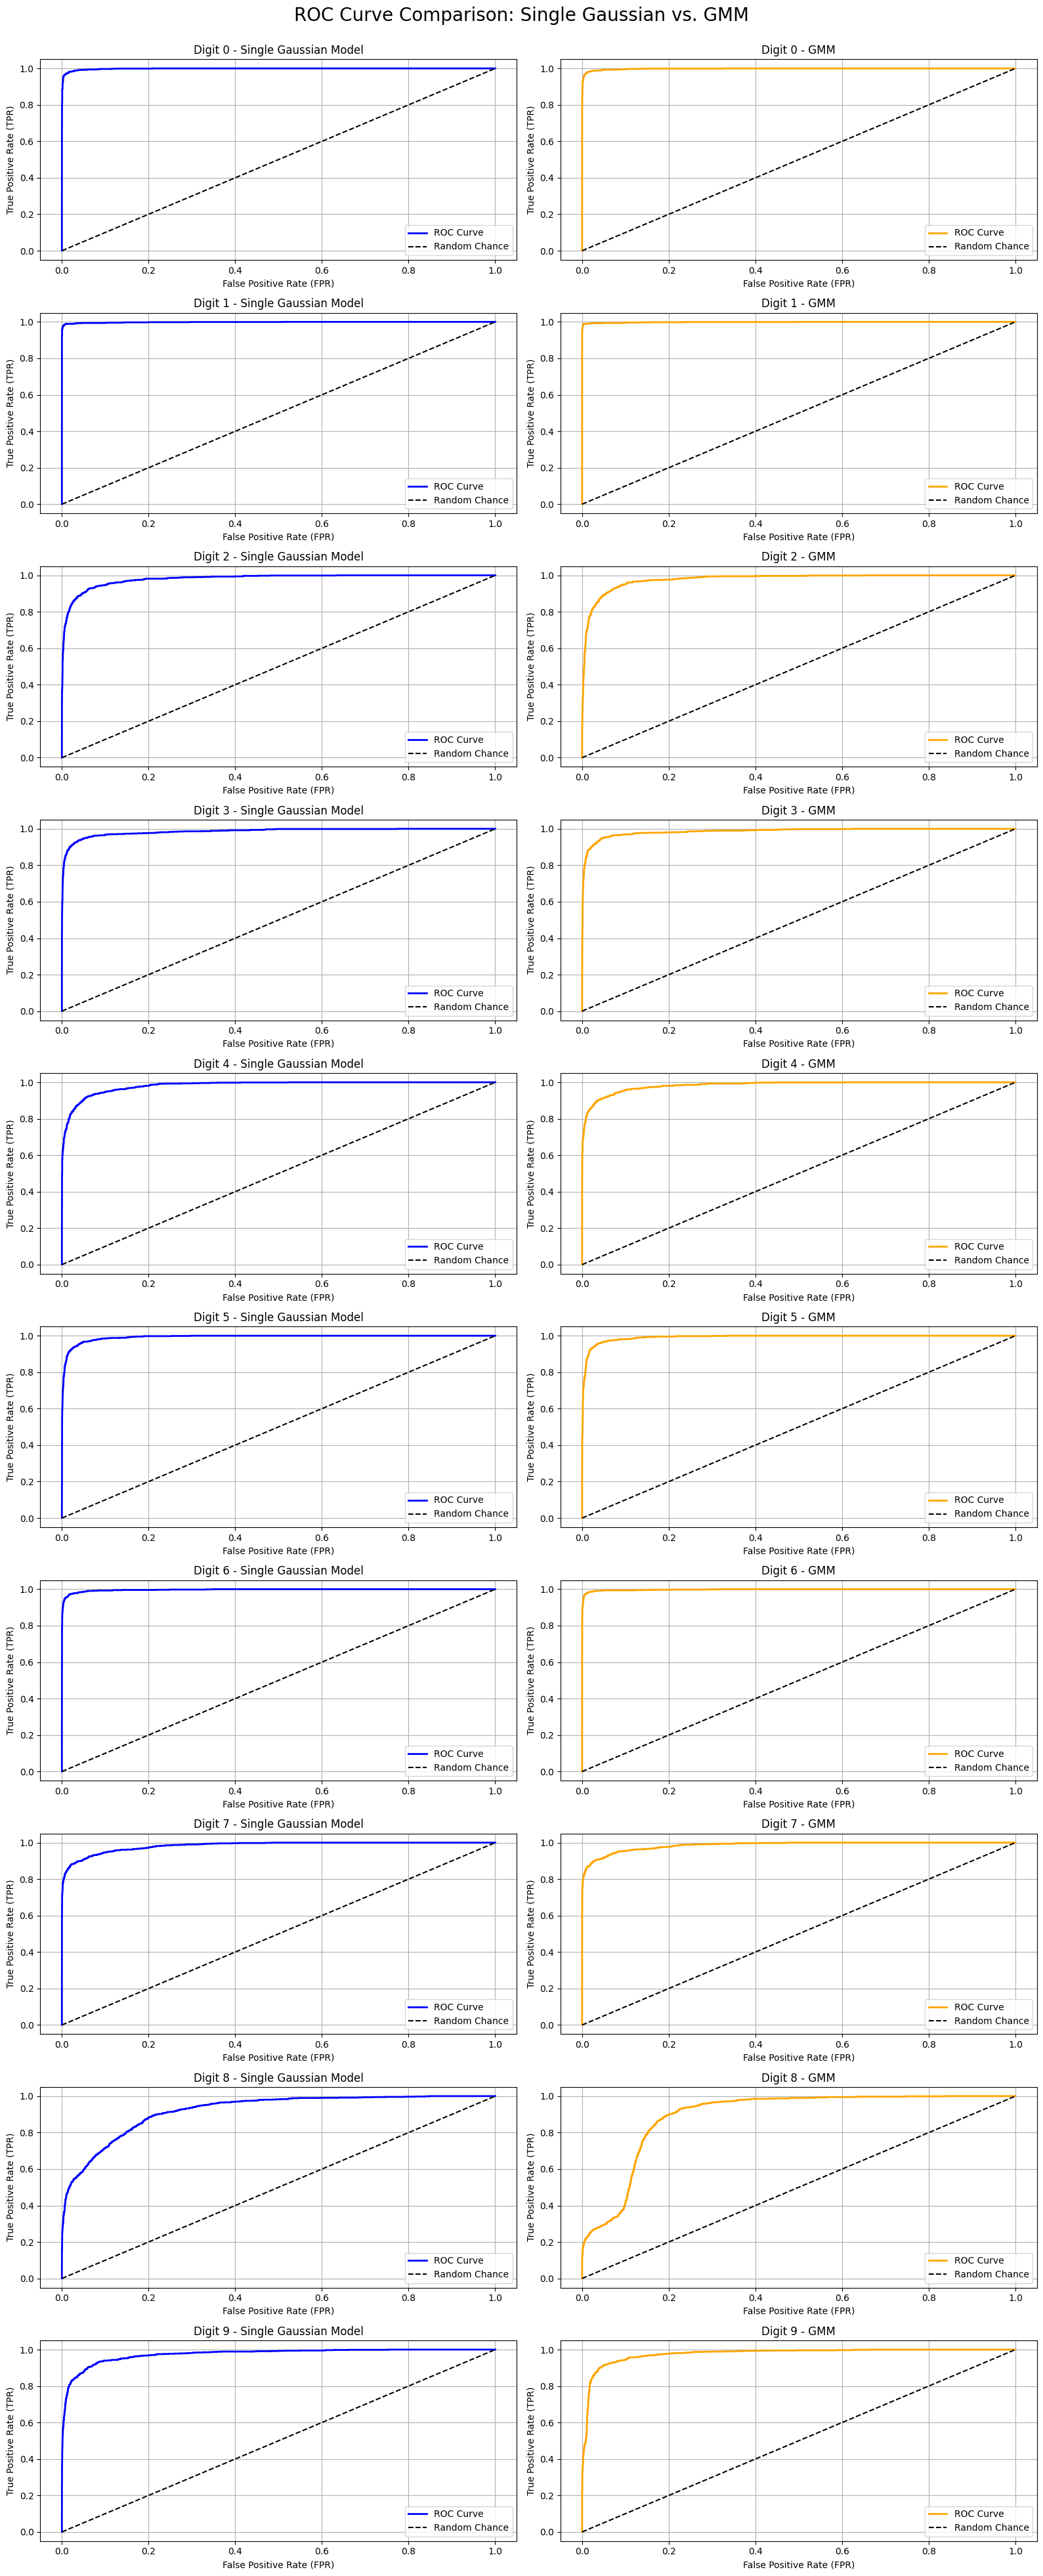

In [15]:

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(16, 40))
fig.suptitle('ROC Curve Comparison: Single Gaussian vs. GMM', fontsize=20)

for c in range(10):
    y_true_binary = (y_test == c).astype(int)

    # --- Plot 1: Single Gaussian Model (Left Column) ---
    ax_gaussian = axes[c, 0]
    scores_gaussian = log_likelihoods_gaussian[:, c]
    fpr_g, tpr_g = calculate_roc_points(y_true_binary, scores_gaussian)

    ax_gaussian.plot(fpr_g, tpr_g, lw=2, label=f'ROC Curve', color='blue')
    ax_gaussian.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Chance')
    ax_gaussian.set_title(f'Digit {c} - Single Gaussian Model')
    ax_gaussian.set_xlabel('False Positive Rate (FPR)')
    ax_gaussian.set_ylabel('True Positive Rate (TPR)')
    ax_gaussian.grid(True)
    ax_gaussian.legend(loc="lower right")

    # --- Plot 2: Gaussian Mixture Model (Right Column) ---
    ax_gmm = axes[c, 1]
    scores_gmm = log_likelihoods_gmm[:, c]
    fpr_gmm, tpr_gmm = calculate_roc_points(y_true_binary, scores_gmm)

    ax_gmm.plot(fpr_gmm, tpr_gmm, lw=2, label=f'ROC Curve', color='orange')
    ax_gmm.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Chance')
    ax_gmm.set_title(f'Digit {c} - GMM')
    ax_gmm.set_xlabel('False Positive Rate (FPR)')
    ax_gmm.set_ylabel('True Positive Rate (TPR)')
    ax_gmm.grid(True)
    ax_gmm.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# **6. ROC Curve Comparison: Single Gaussian Model vs GMM**

This section compares the ROC performance of both models for each digit (**0–9**).  
Each subplot represents the ROC curve showing the trade-off between **True Positive Rate (TPR)** and **False Positive Rate (FPR)**.  
A curve that lies closer to the **top-left corner** indicates **better classification performance**.

---

## **General Overview**

- Both models demonstrate **excellent ROC performance** across all digits, with most curves approaching the ideal top-left region.  
- The **Gaussian Mixture Model (GMM)** consistently achieves **superior or equal** performance compared to the **Single Gaussian Model (SGM)**.  
- Minor variations appear across digits, reflecting differences in **feature distribution complexity**.

---

## Digit-by-Digit Comparison

| Digit | Better Model | Observations |
|:------|:--------------|:--------------|
| **0** | **GMM** | Both curves are excellent, but GMM hugs the top-left corner more tightly (TPR≈1 at FPR≈0). |
| **1** | **GMM** | The orange curve rises faster and stays above the blue — slightly higher accuracy. |
| **2** | **GMM** | Very close, but GMM maintains a slightly higher TPR at mid FPR values. |
| **3** | **GMM** | Clear advantage for GMM — sharper and earlier rise toward TPR=1. |
| **4** | **GMM** | GMM reaches higher TPR earlier, indicating better separation performance. |
| **5** | **GMM** | Noticeably better; it achieves near-perfect TPR with minimal FPR. |
| **6** | **GMM** | GMM rises faster and remains higher across almost all FPRs. |
| **7** | **GMM** | Both are close, but GMM maintains a slightly higher trajectory in the middle region. |
| **8** | **Single Gaussian Model (SGM)** | The only exception — SGM performs better at low FPR; GMM dips slightly early. |
| **9** | **GMM** | Both are strong, but GMM’s smoother curve indicates more stable overall performance. |

---
